In [ ]:
!pip install -q transformers torch sentencepiece underthesea openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.nn import CrossEntropyLoss

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df_train = pd.read_csv("/content/df_train_clean.csv")
df_dev   = pd.read_csv("/content/df_dev_clean.csv")
df_test  = pd.read_csv("/content/df_test_clean.csv")

In [ ]:
for df in (df_train, df_dev, df_test):
    if 'label' not in df.columns:
        if 'Toxicity' in df.columns:
            df['label'] = df['Toxicity']
    df['content_clean'] = df['content_clean'].fillna('').astype(str)
    df['label'] = df['label'].astype(int)

label2id = {'non-toxic': 0, 'toxic': 1}
id2label = {0: 'non-toxic', 1: 'toxic'}

classes = np.array([0, 1])
weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=df_train["label"].to_numpy()
)
class_weights = torch.tensor(weights, dtype=torch.float)

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        txt = self.texts[idx]
        label = self.labels[idx]
        enc = self.tokenizer(
            txt,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item['labels'] = torch.tensor(label, dtype=torch.long)
        return item

In [ ]:
MODEL_NAME = "vinai/phobert-base"
tokenizer  = AutoTokenizer.from_pretrained(MODEL_NAME)
model      = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
)

train_ds = SentimentDataset(
    df_train["content_clean"].tolist(),
    df_train["label"].tolist(),
    tokenizer
)
dev_ds = SentimentDataset(
    df_dev["content_clean"].tolist(),
    df_dev["label"].tolist(),
    tokenizer
)
test_ds = SentimentDataset(
    df_test["content_clean"].tolist(),
    df_test["label"].tolist(),
    tokenizer
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = CrossEntropyLoss(weight=class_weights.to(logits.device))
        loss = loss_fct(logits, labels)
        if return_outputs:
            return loss, outputs
        return loss

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy":        accuracy_score(labels, preds),
        "precision_macro": precision_score(labels, preds, average="macro", zero_division=0),
        "recall_macro":    recall_score(labels, preds, average="macro", zero_division=0),
        "f1_macro":        f1_score(labels, preds, average="macro"),
        "f1_micro":        f1_score(labels, preds, average="micro")
    }

In [ ]:
training_args = TrainingArguments(
    output_dir="./phobert_weighted",
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=100,
    eval_steps=500,
    save_steps=500,
    save_total_limit=1,
    do_eval=True,
    report_to="none"
)

In [ ]:
trainer = WeightedTrainer(
    model            = model,
    args             = training_args,
    train_dataset    = train_ds,
    eval_dataset     = dev_ds,
    compute_metrics  = compute_metrics
)

In [ ]:
trainer.train()

Step,Training Loss
100,0.658500
200,0.611500
300,0.564000
400,0.583300
500,0.511100
600,0.442200
700,0.463400
800,0.488700
900,0.414700
1000,0.368100


TrainOutput(global_step=4380, training_loss=0.226222406551412, metrics={'train_runtime': 1886.024, 'train_samples_per_second': 37.115, 'train_steps_per_second': 2.322, 'total_flos': 4604443468800000.0, 'train_loss': 0.226222406551412, 'epoch': 10.0})


=== Evaluation on Dev ===


Accuracy      : 0.898
F1-Macro      : 0.7061670353982301

Classification Report:
              precision    recall  f1-score   support

   non-toxic     0.9232    0.9649    0.9436      1768
       toxic     0.5921    0.3879    0.4688       232

    accuracy                         0.8980      2000
   macro avg     0.7576    0.6764    0.7062      2000
weighted avg     0.8848    0.8980    0.8885      2000



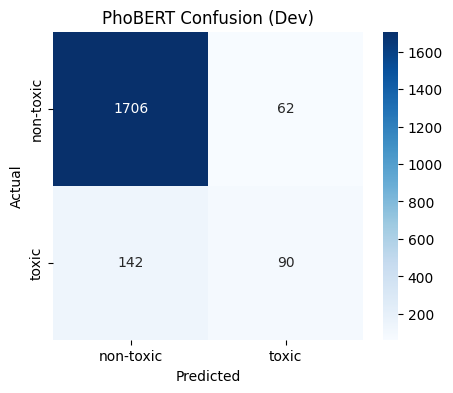


=== Evaluation on Test ===


Accuracy      : 0.907
F1-Macro      : 0.7333340979667442

Classification Report:
              precision    recall  f1-score   support

   non-toxic     0.9346    0.9629    0.9485       890
       toxic     0.6024    0.4545    0.5181       110

    accuracy                         0.9070      1000
   macro avg     0.7685    0.7087    0.7333      1000
weighted avg     0.8980    0.9070    0.9012      1000



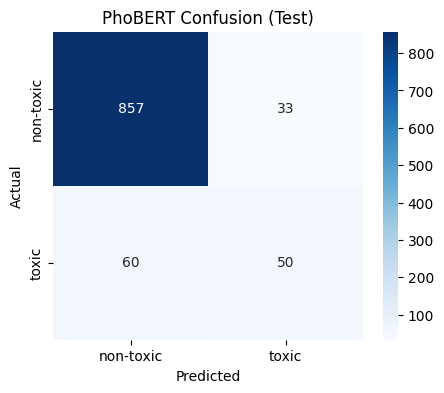

In [ ]:
def evaluate_and_plot(split_name, ds, df):
    print(f"\n=== Evaluation on {split_name} ===")
    metrics = trainer.evaluate(eval_dataset=ds)
    print("Accuracy      :", metrics["eval_accuracy"])
    print("F1-Macro      :", metrics["eval_f1_macro"])
    preds = trainer.predict(ds).predictions.argmax(-1)
    print("\nClassification Report:")
    print(classification_report(df["label"], preds, target_names=['non-toxic', 'toxic'], zero_division=0, digits=4))
    cm = confusion_matrix(df["label"], preds, labels=[0, 1])
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['non-toxic', 'toxic'], yticklabels=['non-toxic', 'toxic'])
    plt.title(f"PhoBERT Confusion ({split_name})")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.show()

evaluate_and_plot("Dev", dev_ds, df_dev)
evaluate_and_plot("Test", test_ds, df_test)